# Analysis on FAO Agricultural Production data

This notebook aims at using other notebooks and python code of this project to establish an global analysis on agricultural production in the world from 1961 to 2023.  
This project uses data from [Food and Agriculture Organization (FAO)](https://www.fao.org/home/en/) of the United Nation  

In [1]:
import sys 
from pathlib import Path

project_folder = str(Path().resolve().parent)
if not project_folder in sys.path:
    sys.path.append(str(Path().resolve().parent))

In [2]:
%load_ext autoreload
%autoreload 2

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from src.data_utils import load_prod_data_utils
from src.analysis_utils import merge_former_ussr_countries, get_top_producers, get_historical_production, \
                    get_historical_rank, get_country_production_items

## Introduction

Text to be written

Analysis run on Production Crops ... only on "production" data, results are all shown in Gtons if not specified

In [4]:
df_prod, country_groups, item_groups = load_prod_data_utils()

✅ Data loaded for production


***Specific note on USSR and former constitutive countries***  
In this analysis, we will keep the specific production for USSR (1961-1991), Russia (1992-2023) and Ukraine (1992-2023), based on their relative high production volumes. Production from other countries from former USSR countries will be aggregated in an unique Area name "Former USSR Countries". 

In [5]:
df_prod = merge_former_ussr_countries(df_prod)

## Global evolution of production over time

In [120]:
global_prod = df_prod[df_prod["Area"]=="World"].groupby("Year").sum().reset_index()

plt.figure(figsize=(12,6))
px.line(data_frame=global_prod, x=global_prod["Year"], y=global_prod["Value"],
       title="Evolution of global world production 1961-2023",
       labels={"Year":"", "Value":"Production in Gtons"})

<Figure size 1200x600 with 0 Axes>

The production across the globe went from around 6.3 Gtons in 1961 to 22.5 Gtons in 2023 with a peak at 23 Gtons in 2022. That is a increase by a 3.6 factor on this period.  
Comparatively, th global population went from 1961 (3.06 billion people) to 2023 (8.06 billion people), which is only a 2.6 factor. 

This might indicates that the global production increased faster than population. To go further, one can analyzes: 
- The access to food for all people and the evolution (and decrease) of bad nutrition across the globe on this period
- The nourishing power for each food product (one product might have a greater nourishing power than another one at the same weight) and their evolution during this period
- The evolution of agricultural practices and the increase in yield


*Source on global population: [WorldBank](https://data.worldbank.org/indicator/SP.POP.TOTL)*

## Historical top producers

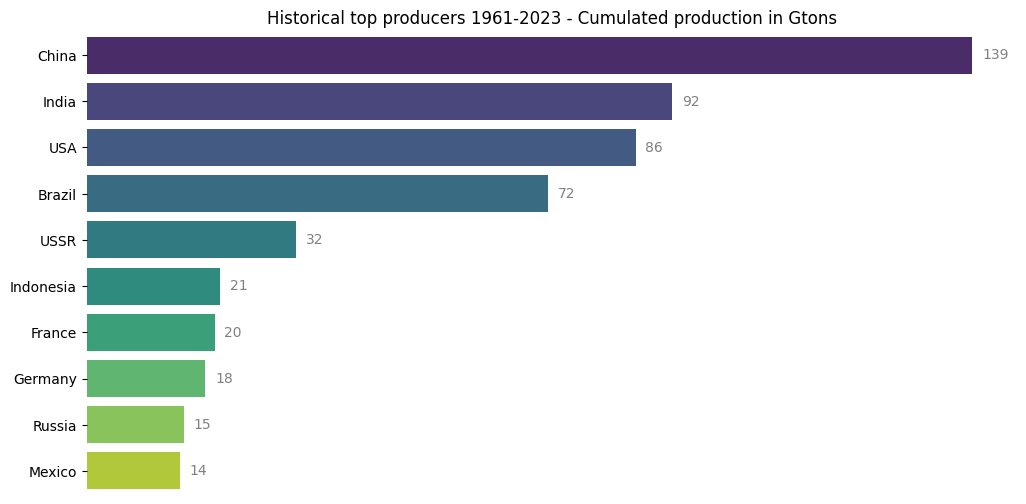

In [7]:
top_global_producers = get_top_producers(df_prod, period=(1961,2023), top_n=10)

plt.figure(figsize=(12,6))

custom_labels = ["China","India","USA","Brazil","USSR","Indonesia","France","Germany","Russia","Mexico"]

ax = sns.barplot(x=top_global_producers["Value"], y=top_global_producers.index, palette="viridis")
ax.set_yticks(ax.get_yticks(), labels=custom_labels)
ax.set_xticks([])
plt.title("Historical top producers 1961-2023 - Cumulated production in Gtons")
plt.xlabel(None)
plt.ylabel(None)
plt.grid(False)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.bar_label(ax.containers[0], fmt="%d", color="grey", padding=7) 

plt.show()

The global production is largely domniated by China (139 Gtons on the period), far away from Inda (92 Gtons) and the USA (86 Gtons). This underlines an Asian dynamic preponderance. USSR is still in Top10 in this period even if exploded in 1991. Russian Federation is also present as top 9, reflecting it maintained an important agricultural production.   
Other countries formed the end of this ranking, but it needs a tendency analysis to check if it is due to former or newer important production volumes. For instance, were Brazil and Indonesia always in top 10 or are they emerging countries ? What about France and Germany ?

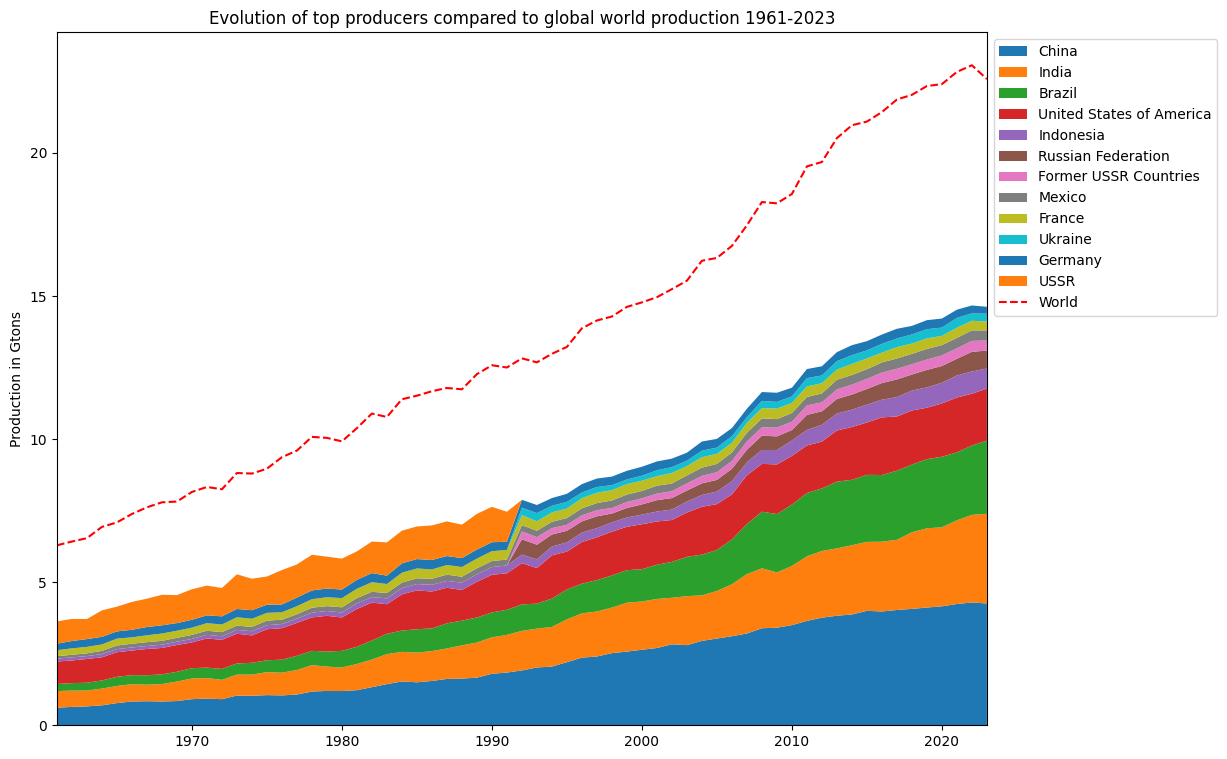

In [59]:
top_historical_producers = np.append(top_global_producers.index, ["Former USSR Countries", "Ukraine"])
top_historical_production = get_historical_production(df_prod, top_historical_producers, period=[1961,2023], product=None)

plt.figure(figsize=(12,9))

plt.stackplot(top_historical_production.columns,
             top_historical_production,
             labels=top_historical_production.index)

sns.lineplot(data=global_prod, x="Year", y="Value", label="World", color="r", ls="--")

plt.title("Evolution of top producers compared to global world production 1961-2023")
plt.legend(bbox_to_anchor=(1,1))
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

Key elements: 
- The top 10 agricultural countries ever from data records produces around 50% of the global production across the globe 
- China is, almost from the beginning, the biggest producer, and mainly drives the increase over the year. 
- India and Brazil are just behind China, and have known a boom in production in the late 2000s driving the boom globally
- United States production is still one of the most important, but have grown more slowly than the three first producers
- USSR was one of the biggest producers, and its explosion has lowered the production in 1992 but rapidly has been covered by production from Russia, Ukraine and other former USSR countries (all included in the plot to keep consistency between periods)
- Indonesia is involved in the Asian dynamics in the domination for agricultural production

## Evolution of top producers

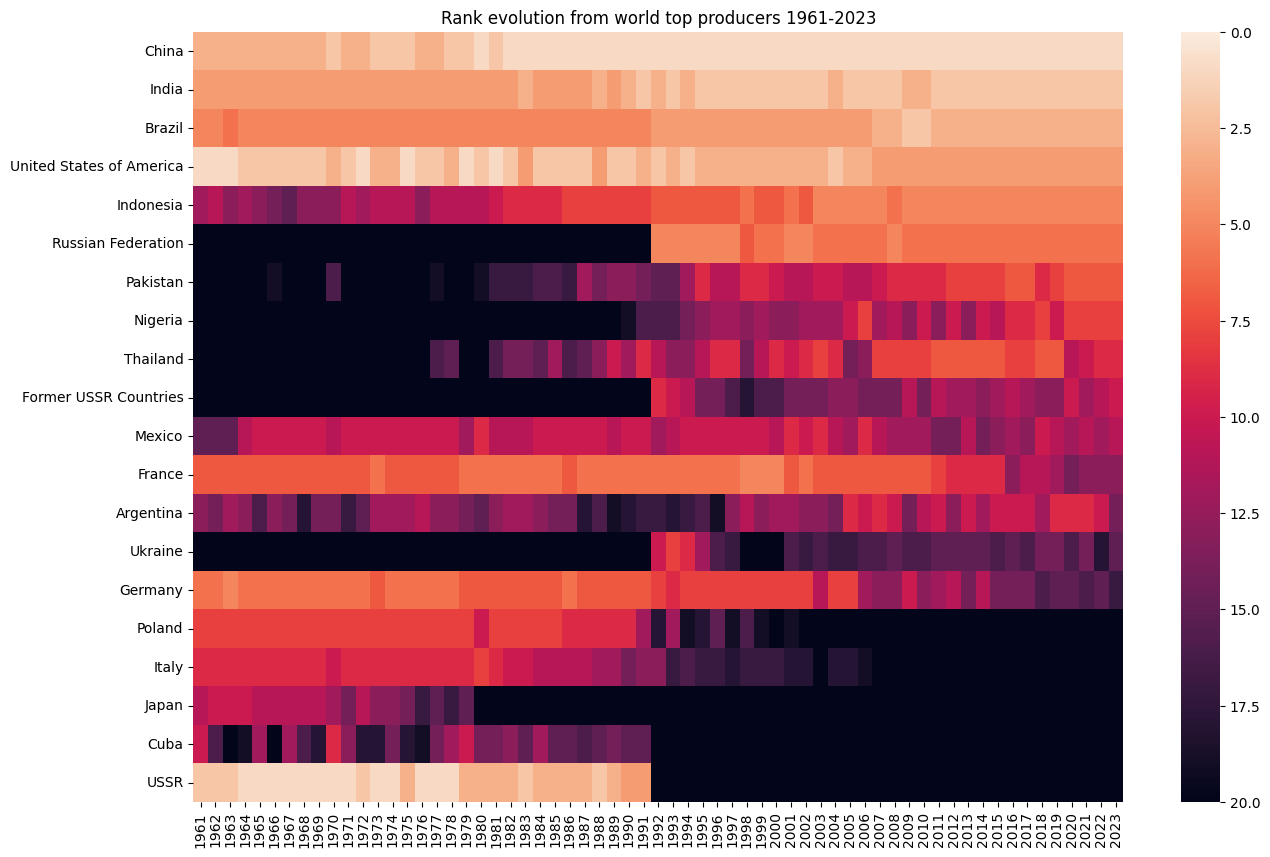

In [104]:
countries = set(df_prod["Area"].unique()) - set(country_groups)
top_historical_ranks = get_historical_rank(df_prod, countries=countries, top_n=10)

plt.figure(figsize=(15,10))

ax = sns.heatmap(top_historical_ranks, vmin=0, vmax=20, cmap="rocket_r")
ax.set_title("Rank evolution from world top producers 1961-2023")
ax.set_ylabel(None)
ax.set_xlabel(None)
plt.gcf().axes[1].invert_yaxis()
plt.show()

The plot shows the rank evolution for each country that has been one year in the top 10 of global agricultural producers in the world. It shows several dynamics: 
- Some historical top producers have always been there and are still top : China, India, Brazil, USA, or even have gained rank : Indonesia
- Some historical top producers have slowly fade away from top10 and even top20 especially from the beginning of 1990s: Cuba, Japan, Italy or Poland
- Other historical were longer in top 10 but are slowly decreasing in ranking : France, Germany
- Letting aside their particularity, USSR, Russia and former USSR countries have always been among top producers
- Some new players have come into the competition and are exploding since 1980s (Thailand, Pakistan) or 1990s (Nigeria) and are participating in new emerging countries

**Key take-aways** : if the global production is still mainly dominated by a few countries (China, India, Brazil, USA, and to some extent Indonesia, and Russia and former USSR countries), new players are emerging in agricultural production (Pakistan, Nigeria, Thailand), surpassing old top producers that begin to lag behind (Germany, France, or more extensively Japan, Italy, Poland)

In [146]:
historical_production = get_historical_production(df_prod, countries).unstack().reset_index().rename(columns={0:"Value"})
historical_production["Rank"] = historical_production.groupby("Year")["Value"].rank(ascending=False)
historical_production = historical_production[historical_production["Rank"]<=10]
historical_productionget_top

fig = px.scatter_geo(
    historical_production,
    locations="Area",
    locationmode="country names",
    size="Value",
    color="Area",
    hover_name="Area",
    animation_frame="Year",
    projection="natural earth",
    title="Evolution of top 10 agricultural producers (1961–2023)",
    size_max=70
)

fig.show()

From this animation, we can clearly see: 
- An everlasting increase of the production from top producers
- In the 1960s, the production is mainly dominated by former top countries : US, USSR, Europe ; but emerging countries are already present : China, India, Brazil. 
- By the end of data records, we see a shift in world dyanmics, as agricultural production is mainly driven by Asian countries (China and India still in top, joined by Indonesia, Thailand, Pakistan) and supported by Brazil (#3) and Nigeria. Europe have downfallen from this top 10 : no country is longer in top 10

## Focus on winners

### China

In [158]:
china_prod = get_country_production_items(df_prod, "China")
px.line(data_frame=china_prod, 
       x="Year",
       y="Value",
       color="Item",
       title="Evolution of production in China",
       labels={"Year":"","Value":"Production in Gtons"})

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Key elements</b> </br>
    <ul>
    <li>Main products that China is currently producing are Cereals and Vegetables, far away from other products : x3 compared to Fruit production, x4 compared to Roots, x6 compared to sugar crops or Meat</li>
    <li>Back in 1960s, the main products were Cereals (already), Roots and Vegetables</li>
    <li>Products that mainly driven the increase in the production are Cereals (x6 in 70 years) and Vegetables (x12)</li>
    </ul>
</div>

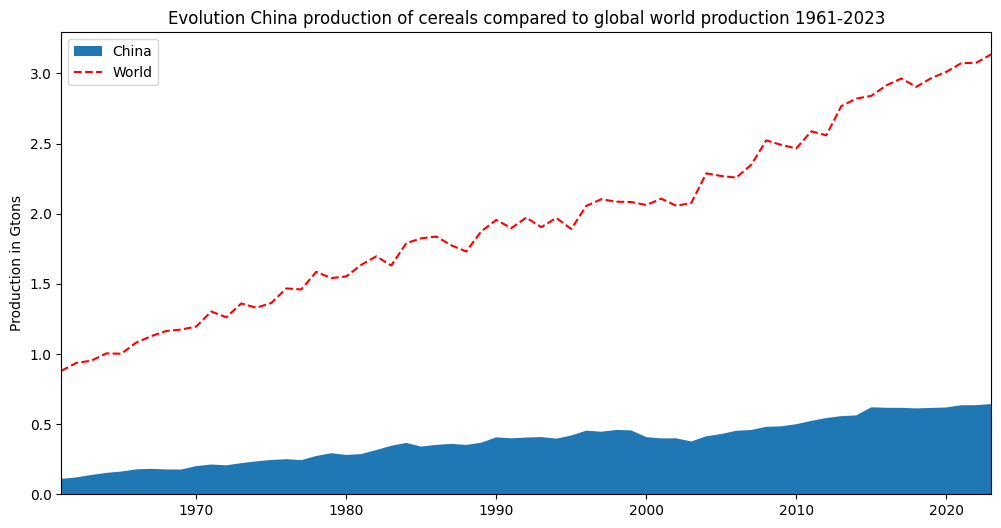

In [201]:
historic_cereals_china = get_historical_production(df_prod, ["China"], period=[1961,2023], product="Cereals, primary")
historic_cereals_world = get_historical_production(df_prod, countries, period=[1961,2023], product="Cereals, primary").sum()

plt.figure(figsize=(12,6))
plt.stackplot(historic_cereals_china.columns,
             historic_cereals_china,
             labels=["China"])

sns.lineplot(data=historic_cereals_world, label="World", color="r", ls="--")

plt.title("Evolution China production of cereals compared to global world production 1961-2023")
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

In [213]:
historic_cereals_china[1961].values / historic_cereals_world[1961] * 100

array([12.4679563])

In [214]:
historic_cereals_china[2023].values / historic_cereals_world[2023] * 100

array([20.51798264])

In [229]:
get_historical_production(df_prod, countries, period=[1961,2023], product="Cereals, primary")[2023].nlargest(5)

Area
China                       0.643446
United States of America    0.462632
India                       0.374600
Brazil                      0.155877
Russian Federation          0.136708
Name: 2023, dtype: float64

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Key elements</b> </br>
    China production on Cereals have grown from 12% of global production to 20%. It is the biggest producer in 2023, followed by the US, India, Brazil and Russia
</div>

### India

In [160]:
india_prod = get_country_production_items(df_prod, "India")
px.line(data_frame=india_prod, 
       x="Year",
       y="Value",
       color="Item",
       title="Evolution of production in India",
       labels={"Year":"","Value":"Production in Gtons"})

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Key elements</b> </br>
    India has based its increase in agricultural production on its historical products: Sugar Crops and Cereals. However, it slowly developed various other products to support its global production : Milk, Vegetables, Fruits, or even Roots
</div>

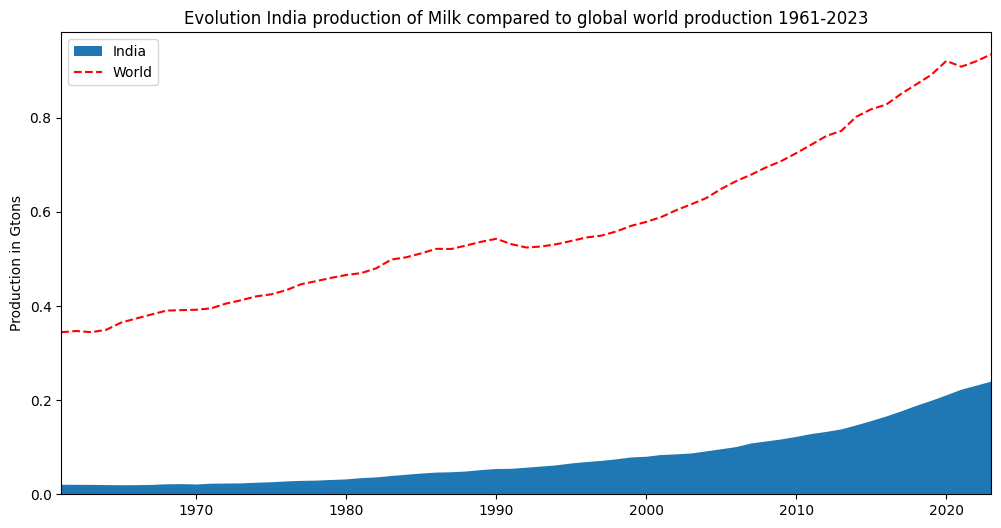

In [217]:
historic_milk_india = get_historical_production(df_prod, ["India"], period=[1961,2023], product="Milk, Total")
historic_milk_world = get_historical_production(df_prod, countries, period=[1961,2023], product="Milk, Total").sum()

plt.figure(figsize=(12,6))
plt.stackplot(historic_milk_india.columns,
             historic_milk_india,
             labels=["India"])

sns.lineplot(data=historic_milk_world, label="World", color="r", ls="--")

plt.title("Evolution India production of Milk compared to global world production 1961-2023")
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

In [220]:
historic_milk_india[1961].values / historic_milk_world[1961] * 100

array([5.91982839])

In [222]:
historic_milk_india[2023].values / historic_milk_world[2023] * 100

array([25.60377916])

In [230]:
get_historical_production(df_prod, countries, period=[1961,2023], product="Milk, Total")[2023].nlargest(5)

Area
India                       0.239307
United States of America    0.102703
Pakistan                    0.064582
China                       0.047267
Brazil                      0.036742
Name: 2023, dtype: float64

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Key elements</b> </br>
    Milk production in India has exploded comparatively from the rest of the world, as from 6% of world production, it is now at 25% of the world production. India is the biggest producer of milk in the world, far from the US (x2.4 the production) Pakistan (x3.7), or China (x5)
</div>

### Brazil

In [161]:
brazil_prod = get_country_production_items(df_prod, "Brazil")
px.line(data_frame=brazil_prod, 
       x="Year",
       y="Value",
       color="Item",
       title="Evolution of production in Brazil",
       labels={"Year":"","Value":"Production in Gtons"})

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Key elements</b> </br>
    Brazil boom in agricultural production is mainly and almost only due by its production on Sugar crops: from 0.06 Gtons in 1961 to a maximum of 0.78 Gtons in 2023, this represents a + 1200% increase !
</div>

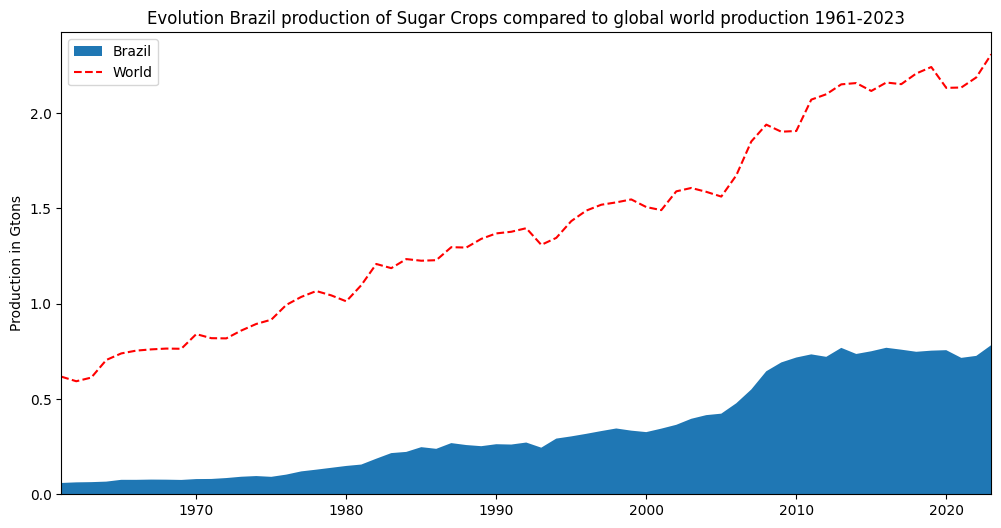

In [223]:
historic_sugar_brazil = get_historical_production(df_prod, ["Brazil"], period=[1961,2023], product="Sugar Crops Primary")
historic_sugar_world = get_historical_production(df_prod, countries, period=[1961,2023], product="Sugar Crops Primary").sum()

plt.figure(figsize=(12,6))
plt.stackplot(historic_sugar_brazil.columns,
             historic_sugar_brazil,
             labels=["Brazil"])

sns.lineplot(data=historic_sugar_world, label="World", color="r", ls="--")

plt.title("Evolution Brazil production of Sugar Crops compared to global world production 1961-2023")
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

In [225]:
historic_sugar_brazil[1961].values / historic_sugar_world[1961] * 100

array([9.62100117])

In [226]:
historic_sugar_brazil[2023].values / historic_sugar_world[2023] * 100

array([33.90295511])

In [231]:
get_historical_production(df_prod, countries, period=[1961,2023], product="Sugar Crops Primary")[2023].nlargest(5)

Area
Brazil      0.782586
India       0.490533
China       0.114150
Thailand    0.093982
Pakistan    0.087670
Name: 2023, dtype: float64

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Key elements</b> </br>
    Brazil production for Sugar Crops has exploded compared to other countries, and is one of the 2 leading countries over the Suger Crops production. It went from 9.6% of the global production in 1961 to more than 1/3 of the global prod in 2023. It is by far the biggest producer along with India (x1.6). Behind, we can find China (factor x7 less), Thailand (x8) or Pakistan (x9)

</div>

## Focus on USSR

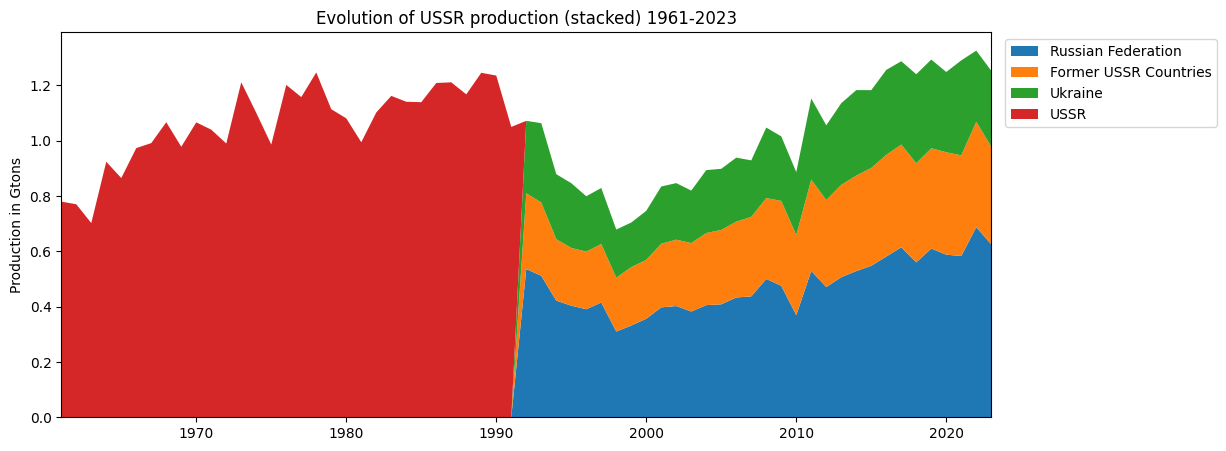

In [265]:
ussr_historical_prod = get_historical_production(df_prod, ["USSR","Former USSR Countries","Russian Federation","Ukraine"])

plt.figure(figsize=(12,5))

plt.stackplot(ussr_historical_prod.columns,
             ussr_historical_prod,
             labels=ussr_historical_prod.index)

plt.title("Evolution of USSR production (stacked) 1961-2023")
plt.legend(bbox_to_anchor=(1.25,1))
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

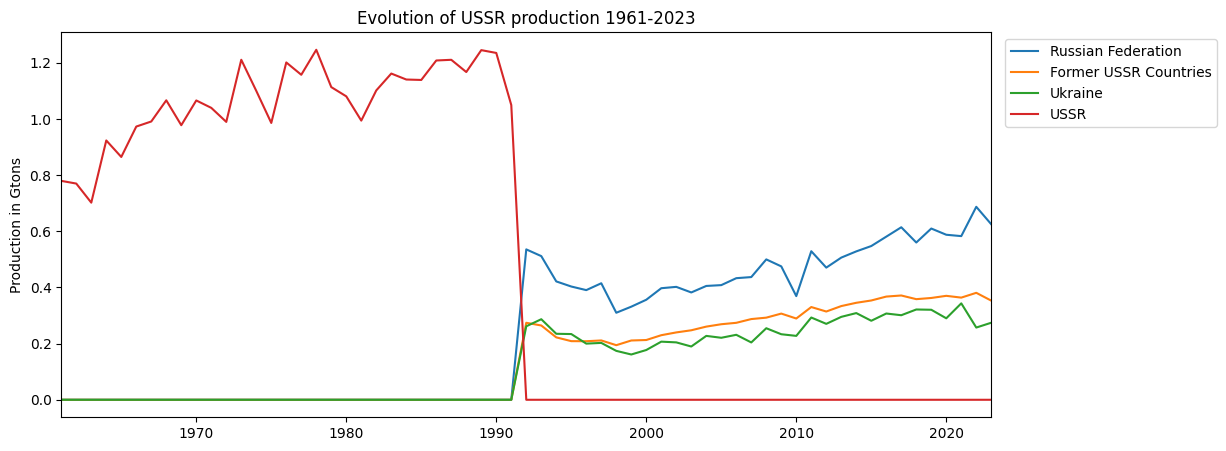

In [264]:
plt.figure(figsize=(12,5))

for country in ussr_historical_prod.index:
    plt.plot(ussr_historical_prod.loc[country,:], label=country)

plt.title("Evolution of USSR production 1961-2023")
plt.legend(bbox_to_anchor=(1.25,1))
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Key elements</b> </br>
    When the USSR exploded and seperated into various countries, we can clearly see a fall in production, especially driven by the Russian Federation. After that, production levels are relatively stable, let alone for a new fall in production for Russia un 2010
</div>